# Force chains in emulsion gels


## About this notebook
In this notebook we perform the analysis of the experimental data. The data are stored in the `data` folder

In [1]:
ls data

phi_p_0.8/    phi_p_1.5/    phi_p_2.0/    stressTensor/
phi_p_1.2/    phi_p_1.7/    phi_p_2.3/


Each folder contains pure `txt` files with the original data from Jun and `xyz` files that can be rendered in `Ovito` or `VMD`.

In [2]:
ls data/phi_p_0.8/

Contact_center.txt   contacts.xyz         particle_center.txt
TCC/                 coords.xyz
box.txt              inputparameters.ini


Lengthy and complex algorithms should be stored in the folder `src`

In [3]:
ls src

__pycache__/           geometry.py            merge_coord_stress.py
convert_txt2xyz.py     io.py                  network.py


## Visualising the data

We first import the basic numerical and visuaisation modules. If they are missing, thhey can be install via `pip install module-name`. For example 

`pip install ipyvolume`

In [4]:
import numpy as np
import scipy as sp
import ipyvolume as ipv
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [5]:
%load_ext autoreload
%autoreload 2
from src import io

In [38]:
pol = 0.8
centres = io.Centres(f"data/phi_p_{pol}/coords.xyz")
contacts = io.Contacts(f"data/phi_p_{pol}/contacts.xyz")

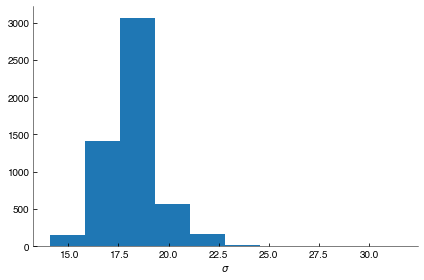

In [7]:
plt.hist(2*centres.radius); plt.xlabel('$\sigma$');

In [8]:
x, y, z = centres.unpack()
color = np.array([(x-x.min())/x.ptp(),np.ones_like(x), np.ones_like(x)]).T
ipv.scatter(x, y, z, size=centres.radius/2.5, marker="sphere", color=color)

x, y, z = contacts.unpack()
ipv.scatter(x, y, z, size=0.9, marker="sphere", color='red')
ipv.show()

## Example of analysis

We show hee how we can proceed to explore the data. For example, we get the nearest contacts for every particle centre. To do so, we fix a cutoff radius `rcut` for our search. 

In [9]:
from scipy.spatial import cKDTree

rcut = centres.radius.mean()*1.2
centre_tree = cKDTree(centres.coord)
contact_tree = cKDTree(contacts.coord)
centre_contacts=centre_tree.query_ball_tree(contact_tree, rcut)

By the same means, we can easily estimate the radial distribution function `g(r)`.

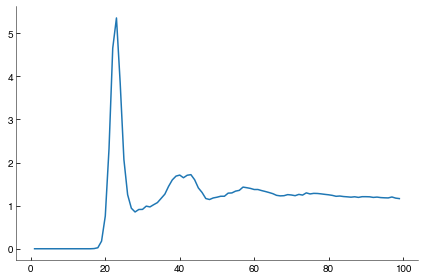

In [10]:
centres.get_gr()
plt.plot(centres.gr['r'],centres.gr['g']);

Similarly, we can compute the coordination within a larger cutoff, for example around the first minimum of `g(r)`.

In [11]:
rcut = 27
neighs=centre_tree.query_ball_tree(centre_tree,rcut)
coordination = [len(n)-1 for n in neighs]

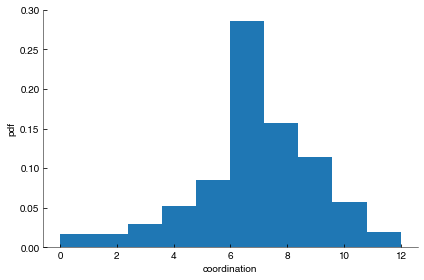

In [12]:
plt.hist(coordination, density=True); plt.xlabel('coordination');plt.ylabel('pdf');

In [13]:
centre_contacts_weights = []
num_contacts = []
for c in centre_contacts:
    w = []
    if len(c)>0:
        w=list(contacts.volume[c])
    
    num_contacts.append(len(c))
    centre_contacts_weights.append(w)

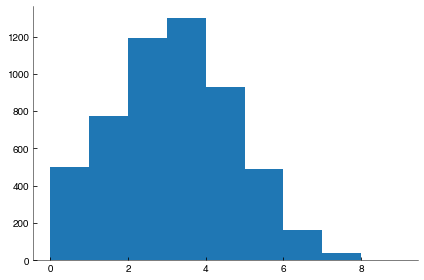

In [14]:
plt.hist(num_contacts,bins=np.arange(10));

# Stress Tensor

The stress data from Jun are stored in a different sub-folder

In [15]:
ls data/stressTensor/

0.8/ 1.2/ 2.0/


In [39]:
ls data/stressTensor/'{pol}'

major_stress.txt           stress_tensor.pkl
minor_stress.txt           stress_trace.txt
particle_stress_index.txt


The stress data are easily read into the `centres` object

In [40]:
centres.get_stress_info(f'data/stressTensor/{pol}/', rcut=28)

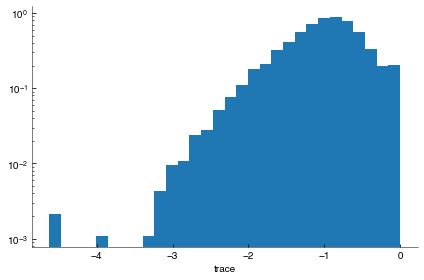

In [41]:
plt.hist(centres.trace,bins=30, density=True);
plt.yscale('log')
plt.xlabel('trace');

The  minor stress is the most negative one as we are following the tension-positive convention of Peteres _et al_ PRE 2005

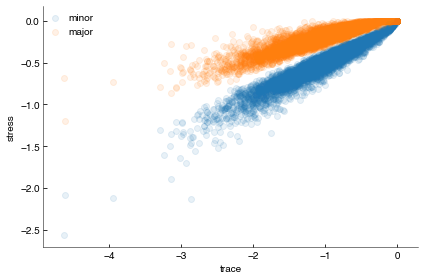

In [42]:
plt.scatter(centres.trace,centres.minor, alpha=0.1, label='minor')
plt.scatter(centres.trace,centres.major, alpha=0.1, label = 'major')
plt.xlabel('trace')
plt.ylabel('stress');
plt.legend();

Compute a weighted g(r) 

In [43]:
centres.get_gr(rmax=100,dr=1.)
# select a threshold
def compare_g(threshold):
    mgr = centres.get_masked_gr(centres.trace, threshold)
    plt.plot(centres.gr['r'],centres.gr['g'])
    plt.plot(mgr['r'],mgr['g'])
    
interact(compare_g,threshold=widgets.FloatSlider(min=-3, max=0, value=-1,continuous_update=False))

interactive(children=(FloatSlider(value=-1.0, continuous_update=False, description='threshold', max=0.0, min=-…

<function __main__.compare_g(threshold)>

In [44]:
interact(centres.plot_clusters,threshold=widgets.FloatSlider(min=-3, max=0, value=-1,continuous_update=False), rcut=fixed(28),size=fixed(5.0));


interactive(children=(FloatSlider(value=-1.0, continuous_update=False, description='threshold', max=0.0, min=-…

In [45]:
centres.pearsonr_coordination_z_slice(200,centres.local_aniso, plot=False)

0.027430915564470543

In [46]:
zs = np.arange(100,380,10)
profiles = centres.all_pearson_profiles(zs)
print (profiles.keys())

dict_keys(['z', 'trace_profile', 'aniso_profile', 'major_profile', 'minor_profile'])


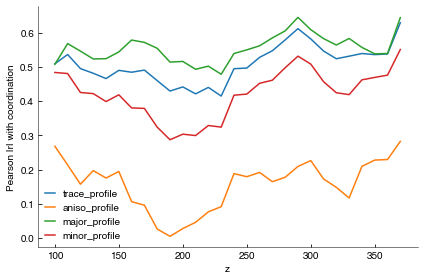

In [47]:
for k,v in profiles.items():
    if 'profile' in k:
        plt.plot(zs,np.absolute(v),label=k)
plt.legend()
plt.xlabel('z'),plt.ylabel('Pearson |r| with coordination');
plt.savefig('figs/profile_ correlations.png')

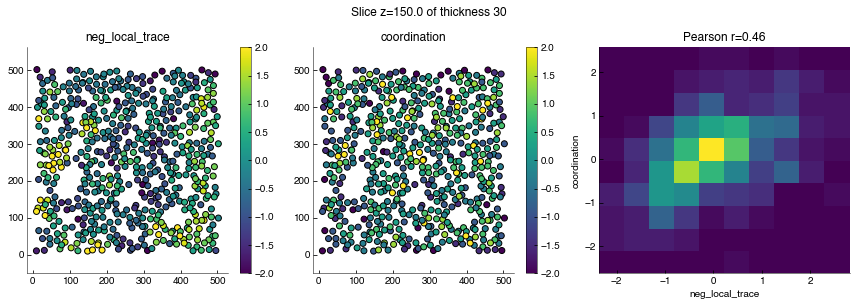

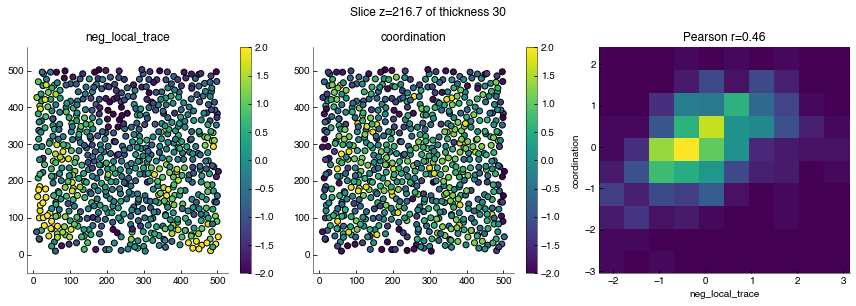

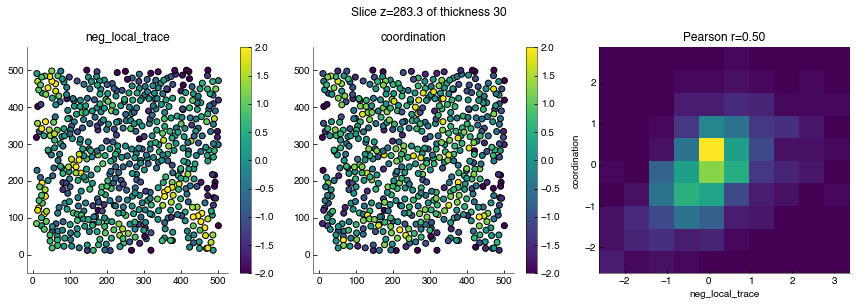

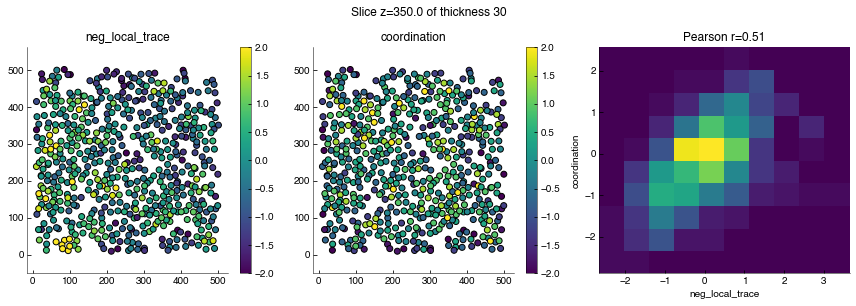

In [52]:
for z in np.linspace(150,350,4):
    centres.plot_sample_slices(z,-centres.local_trace,centres.stress_coordination, feature_scaling=True, thickness=30,border=10)
    plt.savefig(f'figs/correlations/p{pol}/traceVScoord-z{z}.pdf')


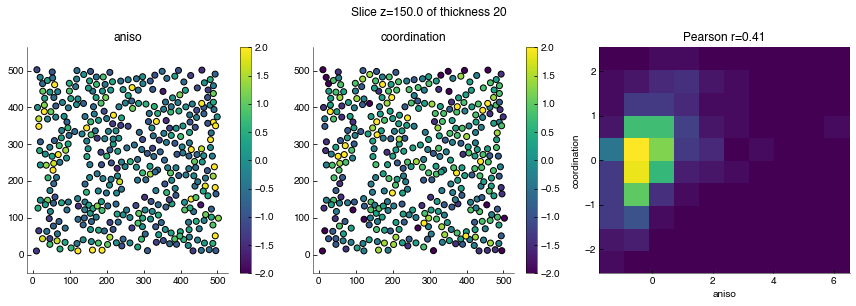

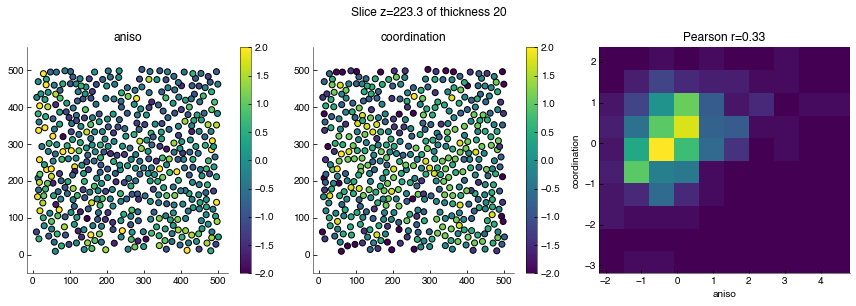

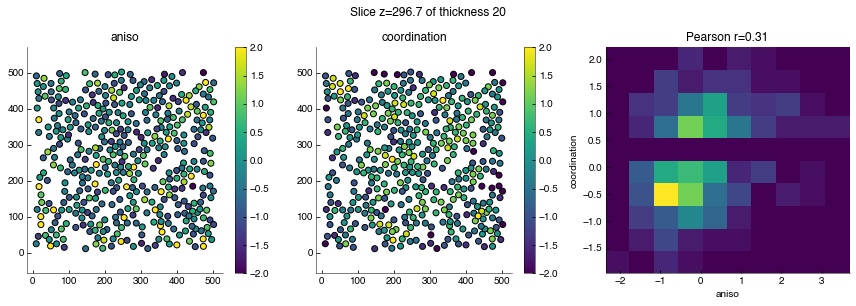

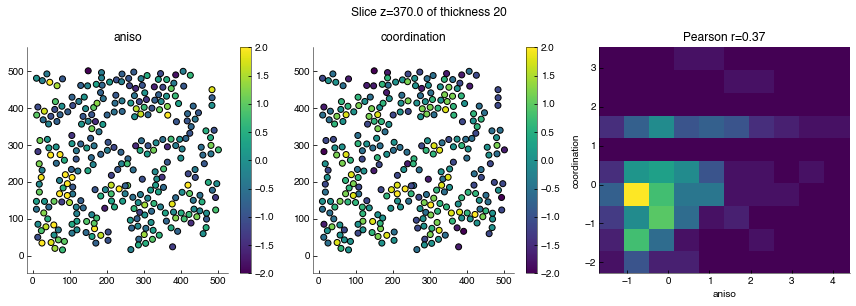

In [51]:
for z in np.linspace(150,370,4):
    centres.plot_sample_slices(z,centres.aniso,centres.stress_coordination, feature_scaling=True, thickness=20,border=20)
    plt.savefig(f'figs/correlations/p{pol}/anisoVScoord-z{z}.pdf')

In [ ]:
for z in np.linspace(150,370,4):
    centres.plot_sample_slices(z,centres.aniso,centres.trace, feature_scaling=True, thickness=20,border=20)
    plt.savefig(f'figs/correlations/p{pol}/anisoVScoord-z{z}.pdf')

## Network construction

We need to find common contacts to construct edges.

In [31]:
import networkx as nx
from src import network

peak 137.0625
mean 114.1870162433228
std 53.1959160143887


172.0

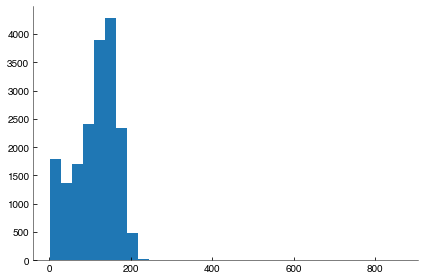

In [32]:
plt.hist(contacts.volume,bins=32);
H, e = np.histogram(contacts.volume,bins=32)
print('peak',e[:-1][H.argmax()])
print('mean', np.mean(contacts.volume))
print('std', np.std(contacts.volume))
np.percentile(contacts.volume,90)

In [33]:
G = network.ContactNetwork(centres,contacts,percentile=95)

 The number of contacts with no neighbouring particles is 35


In [34]:
G.export_components()

From the Graph we can extract many possible metrics. For example the **deegre assortativity** measures to what extent nodes with similar degrees cluster together (see Newman PRE 67, 026126 􏰒2003􏰀).

In [35]:
nx.degree_assortativity_coefficient(G.graph)

0.11230415771140471

Simple geometrical measures are also possible, such as the **number of triangles**.

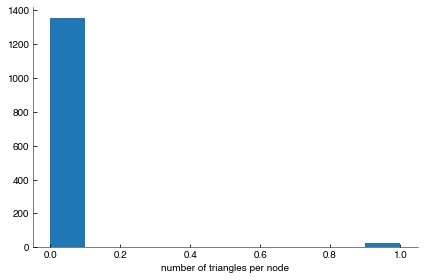

In [36]:
plt.hist(nx.triangles(G.graph).values());
plt.xlabel("number of triangles per node");

We can for example compute the **transitivity** $T$ as
$$T=3 \frac{\# \text { triangles }}{\# \text { triads }}$$
which is $T=1$ for complete graphs (where every pair of nodes is connected by a single edge).

In [37]:
nx.transitivity(G.graph)

0.060759493670886074

![figs/transitivity.png](figs/transitivity.png)